In [1]:
from benchmarks import power_sample
from hyppo.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
from hyppo.sims import *


import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import hyppo
import numpy as np
from numba import njit
from hyppo.independence.base import IndependenceTest
from hyppo._utils import perm_test
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy 
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

import sys
sys.executable
sys.path
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')
sys.path.append('C:\\Users\\siptest\\Desktop\\R-3.6.2\\bin\\x64')

In [3]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

In [14]:

from math import ceil 
from hyppo.sims import indep_sim
#from indep_sim import indep_sim

def _indep_sim_gen(sim, n, p, noise=True):
    """
    Generate x, y from each sim
    """
    #if sim in ["multiplicative_noise", "multimodal_independence"]:
        #x, y = indep_sim(sim, n, p)
        
    if sim == "multiplicative noise": 
        x, y = indep_sim.multiplicative_noise(n, p)
    
    if sim == "multimodal_independence": 
        x, y = indep_sim.multimodal_independence(n,p)
       
    else:
        #x, y = indep_sim(sim, n, p, noise=noise)
        x, y = indep_sim.linear(n, p, noise = noise)
        
    print(y)
    
    return x, y


def _perm_stat(test, sim, n=100, p=1, noise=True):
    """
    Generates null and alternate distributions
    """
    x, y = _indep_sim_gen(sim, n, p, noise=noise)
    obs_stat = test()._statistic(x, y)
    permy = np.random.permutation(y)
    perm_stat = test()._statistic(x, permy)

    return obs_stat, perm_stat

def power(test, sim, n=100, p=1, noise=True, alpha=0.05, reps=1000, auto=False):
    """
    Calculates empirical power
    """
    alt_dist, null_dist = map(
        np.float64,
        zip(*[_perm_stat(test, sim, n, p, noise=noise) for _ in range(reps)]),
    )
    cutoff = np.sort(null_dist)[ceil(reps * (1 - alpha))]
    empirical_power = (alt_dist >= cutoff).sum() / reps

    if empirical_power == 0:
        empirical_power = 1 / reps

    return empirical_power

In [5]:
class UF(): 
    
    def _init_(self): 
        self._name_ = "UF"
            
    def _statistic(self, X, y):
        n = 20 
        d = 2
        pis = [0.05 * i for i in range(1,20)]
        num_trials = 10
     
        return self.mi(X, y, n, d, pis, num_trials)
        
    def uf(self, X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
        
        # Build forest with default parameters.
        model = BaggingClassifier(DecisionTreeClassifier(), 
                                  n_estimators=n_estimators, 
                                  max_samples=max_samples, 
                                  bootstrap=False)
        model.fit(X, y)
        n = X.shape[0]
        K = model.n_classes_
        _, y = np.unique(y, return_inverse=True)
        
        cond_entropy = 0
        for tree_idx, tree in enumerate(model):
            # Find the indices of the training set used for partition.
            sampled_indices = model.estimators_samples_[tree_idx]
            unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
            
            # Randomly split the rest into voting and evaluation.
            total_unsampled = len(unsampled_indices)
            np.random.shuffle(unsampled_indices)
            vote_indices = unsampled_indices[:total_unsampled//2]
            eval_indices = unsampled_indices[total_unsampled//2:]
            
            # Store the posterior in a num_nodes-by-num_classes matrix.
            # Posteriors in non-leaf cells will be zero everywhere
            # and later changed to uniform.
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            est_nodes = tree.apply(X[vote_indices])
            est_classes = y[vote_indices]
            for i in range(len(est_nodes)):
                class_counts[est_nodes[i], est_classes[i]] += 1
            
            row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
            row_sums[row_sums == 0] = 1 # Avoid divide by zero.
            class_probs = class_counts / row_sums[:, None]
            
            # Make the nodes that have no estimation indices uniform.
            # This includes non-leaf nodes, but that will not affect the estimate.
            class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
            
            # Apply finite sample correction and renormalize.
            where_0 = np.argwhere(class_probs == 0)
            for elem in where_0:
                class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
            row_sums = class_probs.sum(axis=1)
            class_probs = class_probs / row_sums[:, None]
            
            # Place evaluation points in their corresponding leaf node.
            # Store evaluation posterior in a num_eval-by-num_class matrix.
            eval_class_probs = class_probs[tree.apply(X[eval_indices])]
            # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
            eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
            cond_entropy += np.mean(eval_entropies)
    
          
        return cond_entropy / n_estimators
            
    def generate_data2(n, d, mu = 1):
        n_1 = np.random.binomial(n, .5) # number of class 1
        mean = np.zeros(d)
        mean[0] = mu
        X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
        
        X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
        y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
      
        return X, y
    
    def generate_data(self, n, d, mu = 1, var1 = 1, pi = 0.5, three_class = False):
        
        means, Sigmas, probs = self._make_params(d, mu = mu, var1 = var1, pi = pi, three_class = three_class)
        counts = np.random.multinomial(n, probs, size = 1)[0]
        
        X_data = []
        y_data = []
        for k in range(len(probs)):
            X_data.append(np.random.multivariate_normal(means[k], Sigmas[k], counts[k]))
            y_data.append(np.repeat(k, counts[k]))
        X = np.concatenate(tuple(X_data))
        y = np.concatenate(tuple(y_data))
        
        return X, y
    
    def _make_params(self, d, mu = 1, var1 = 1, pi = 0.5, three_class = False):
        
        if three_class:
            return self._make_three_class_params(d, mu, pi)
        
        mean = np.zeros(d)
        mean[0] = mu
        means = [mean, -mean]
    
        Sigma1 = np.eye(d)
        Sigma1[0, 0] = var1
        Sigmas = [np.eye(d), Sigma1]
        
        probs = [pi, 1 - pi]
        
        return means, Sigmas, probs
    
    def _make_three_class_params(d, mu, pi):
        
        means = []
        mean = np.zeros(d)
        
        mean[0] = mu
        means.append(copy.deepcopy(mean))
        
        mean[0] = -mu
        means.append(copy.deepcopy(mean))
        
        mean[0] = 0
        mean[d-1] = mu
        means.append(copy.deepcopy(mean))
        
        Sigmas = [np.eye(d)]*3
        probs = [pi, (1 - pi) / 2, (1 - pi) / 2]
        
        return means, Sigmas, probs
    
    def compute_mutual_info(self, d, base = np.exp(1), mu = 1, var1 = 1, pi = 0.5, three_class = False):
        
        if d > 1:
            dim = 2
        else:
            dim = 1
     
        means, Sigmas, probs = self._make_params(dim, mu = mu, var1 = var1, pi = pi, three_class = three_class)
        
        # Compute entropy and X and Y.
        def func(*args):
            x = np.array(args)
            p = 0
            for k in range(len(means)):
                p += probs[k] * multivariate_normal.pdf(x, means[k], Sigmas[k])
            return -p * np.log(p) / np.log(base)
    
        scale = 10
        lims = [[-scale, scale]]*dim
        H_X, int_err = nquad(func, lims)
        H_Y = entropy(probs, base = base)
        
        # Compute MI.
        H_XY = 0
        for k in range(len(means)):
            H_XY += probs[k] * (dim * np.log(2*np.pi) + np.log(np.linalg.det(Sigmas[k])) + dim) / (2 * np.log(base))
        I_XY = H_X - H_XY
        
        return I_XY, H_X, H_Y
    
    def estimate_mi(self, X, y, est_H_Y, norm_factor): 
        
        print(np.array(X))
        print(y)
        
        return (est_H_Y - self.uf(np.array(X), y)) / norm_factor

    
    def mi(self, X, y, n, d, pis, num_trials):
        #def worker(t): 
            #X, y = generate_data(n, d, pi = elem)
            
            #I_XY, H_X, H_Y = compute_mutual_info(d, pi = elem)
            I_XY, H_X, H_Y = self.compute_mutual_info(d)
            norm_factor = min(H_X, H_Y)
            
            _, counts = np.unique(y, return_counts=True)
            est_H_Y = entropy(counts, base=np.exp(1))
            ret = []
            ret.append(self.estimate_mi(X, y, est_H_Y, norm_factor))
            #return tuple(ret)
            return ret[0]

In [6]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 1

In [7]:
simulations = [
    linear,
    multiplicative_noise,
    multimodal_independence
]

tests = [
    UF, 
]

In [8]:
def estimate_power(sim, test):
    est_power = np.array([np.mean([power(test, sim, n=i) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('C:/Users/siptest/Desktop/hyppo/benchmarks/2samp_vs_samplesize/{}_{}.csv'.format(sim.__name__, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [15]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.1s remaining:    0.0s


ValueError: Unknown label type: 'continuous'

In [12]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))
    
    sim_title = [
        "Linear",
        "Multiplicative",
        "Independence"
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = simulations[count]
            
            for test in tests:
                mgc_power = np.genfromtxt('C:/Users/siptest/Desktop/hyppo/benchmarks/2samp_vs_samplesize/{}_MGC.csv'.format(sim.__name__),
                                          delimiter=',')
                power = np.genfromtxt('C:/Users/siptest/Desktop/hyppo/benchmarks/2samp_vs_samplesize/{}_{}.csv'.format(sim.__name__, test.__name__),
                                      delimiter=',')
                
                custom_color = {
                    "Dcorr" : "#377eb8",
                    "Hsic" : "#4daf4a",
                    "MGC" : "#e41a1c",
                }
                if test.__name__ in custom_color.keys():
                    if test.__name__ == "UF":
                        col.plot(SAMP_SIZES, power - mgc_power, custom_color[test.__name__], label=test.__name__, lw=5)
                    else:
                        col.plot(SAMP_SIZES, power - mgc_power, custom_color[test.__name__], label=test.__name__, lw=2)
                else:
                    col.plot(SAMP_SIZES, power - mgc_power, label=test.__name__, lw=1)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(sim_title[count])
    
    fig.text(0.5, 0.08, 'Sample Size', ha='center')
    fig.text(0.08, 0.5, 'Statistical Power Relative to MGC', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('C:/Users/siptest/Desktop/hyppo/benchmarks/figs/2samp_power_sampsize.pdf', transparent=True, bbox_inches='tight')

OSError: C:/Users/siptest/Desktop/hyppo/benchmarks/2samp_vs_samplesize/linear_UF.csv not found.

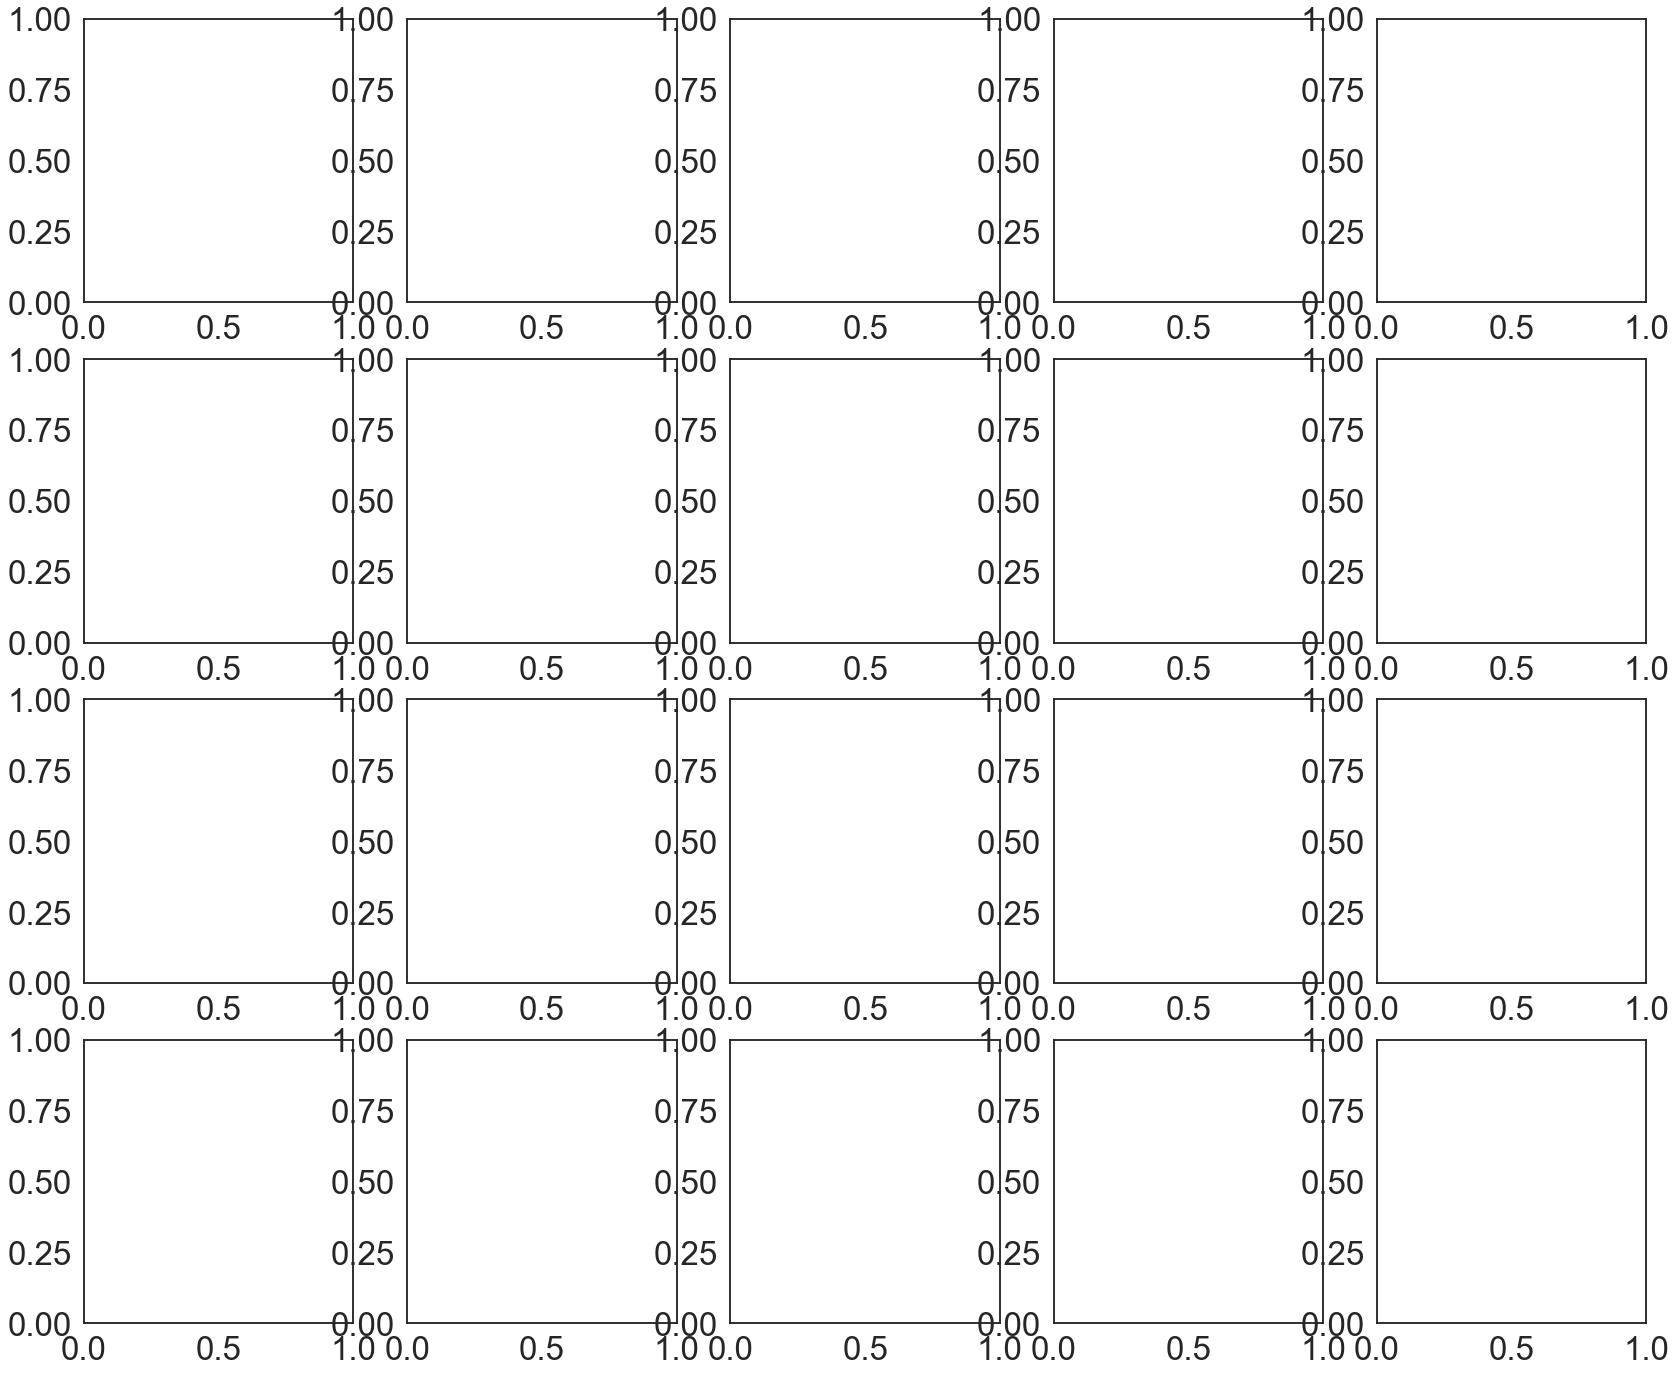

In [13]:
plot_power()